In [18]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import statistics as st
from calendar import isleap

#### Historical ERA5 Inv

In [19]:
#Surface data
t2mData = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
tuv850Data = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')

# Read Orography
OroData = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86)).t2m
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))
tuv850D = tuv850Data.sel(latitude=slice(32,24),longitude=slice(74,86)).t


# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


<xarray.DataArray 'rh' (dayofyear: 63)>
array([1.58040512, 1.60331249, 1.81252372, 1.86940598, 2.37063932,
       2.34071589, 2.28331852, 2.21451783, 2.03124213, 1.95843327,
       2.22060323, 2.07423186, 1.82430089, 1.42262852, 1.61433172,
       1.84041524, 1.92921233, 2.04067516, 1.95114636, 1.83142149,
       1.99396718, 2.01254439, 1.91877055, 1.86815715, 1.65651762,
       1.51658046, 1.29776251, 1.25797415, 1.495139  , 1.73241198,
       1.4556905 , 1.2919116 , 1.22640133, 1.38615525, 1.68050516,
       1.90158951, 1.59280908, 1.53576159, 1.24105477, 1.34037852,
       1.66574526, 1.52177405, 1.46823275, 1.65785134, 1.80721915,
       1.54095626, 1.64314938, 1.59878016, 1.58828437, 1.65648758,
       1.51888812, 1.95310438, 1.86972344, 1.84485221, 1.86694908,
       1.7498132 , 1.76877379, 1.59941995, 1.5265125 , 1.46302307,
       1.41566718, 1.47088003, 1.16015112])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

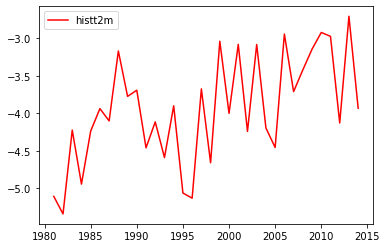

In [20]:


#Calculate rh
rh = tuv850D.values - t2mD.values 
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})

rh_ds.attrs
rh_ds.attrs['units']='%'
rh_ds.attrs['long_name']='inv t850-t2m'


# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask


# Area Average
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh

rhTs=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
# # Historical Moisture
x=np.arange(1981,2015)
ObsERA5=[]
#print(rhTs.time)
for yr in x :
    InDString=np.datetime64(str(yr-1)+'-12-01T09:00:00')
    EnDString=np.datetime64(str(yr)+'-01-31T09:00:00')
   # print(EnDString)
    rhT=rhTs.sel(time=slice(InDString,EnDString))
    #print(rhT.time)
    ObsERA5.append(rhT.mean())
    
    #print(yr)

#print(y)
plt.plot(x,ObsERA5,label='histt2m', color='red')
plt.legend()


rhHistMean1=rhTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]

rhERA5HistMean=rhTs.groupby('time.dayofyear').mean()
rhERA5HistMean
rhERA5HistStd=rhTs.groupby('time.dayofyear').std()
rhERA5HistStd


[-4.644472  -4.204983  -4.0332656 ... -4.4842668 -3.9282548 -3.3667128]


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


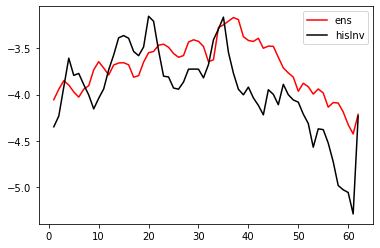

In [21]:
### Historical model BC

# IPSL

rhData  = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_tas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

#Calculate inv
inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t850 - t2m'
# apply mask
inv_ds.inv.values=inv_ds.inv.values*mask
rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))

rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
rhData  = xr.open_dataset('../../Data/CMIP6/EC-Earth3/processed/Regrid_tas_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
tLevData = xr.open_dataset('../../Data/CMIP6/EC-Earth3/processed/Regrid_ta_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

#Calculate inv
inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t850 - t2m'
# apply mask
inv_ds.inv.values=inv_ds.inv.values*mask
rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))


# ACCESS-CM2

rhData  = xr.open_dataset('../../Data/CMIP6/ACCESS-CM2/tasNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
tLevData = xr.open_dataset('../../Data/CMIP6/ACCESS-CM2/taNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

#Calculate inv
inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t850 - t2m'
# apply mask
inv_ds.inv.values=inv_ds.inv.values*mask
rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))



MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS


# # Historical Moisture
x=np.arange(1,63)
rhHistMean1=ensTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH_ens=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]
plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisInv', color='black')

#plt.ylim([275, 295])
plt.legend()




In [22]:
MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS

ensTsMean=ensTs.groupby('time.dayofyear').mean()
ensTsStd=ensTs.groupby('time.dayofyear').std()
ensTsMean


[-4.644472  -4.204983  -4.0332656 ... -4.4842668 -3.9282548 -3.3667128]


<xarray.DataArray 'rh' (dayofyear: 63)>
array([-3.4783864, -3.6436348, -3.6222394, -3.2730489, -3.2435784,
       -3.2041795, -3.1642566, -3.1872182, -3.3719723, -3.4129443,
       -3.423741 , -3.389387 , -3.4975505, -3.4744425, -3.4769242,
       -3.5955443, -3.710326 , -3.7642317, -3.8106747, -3.963584 ,
       -3.87684  , -3.9142644, -3.9939213, -3.9384928, -3.9821615,
       -4.135853 , -4.085917 , -4.091015 , -4.1869273, -4.3246965,
       -4.4263935, -4.2137904, -4.0552535, -3.941619 , -3.8496296,
       -3.8955333, -3.9706166, -4.027256 , -3.9412475, -3.903306 ,
       -3.731145 , -3.643014 , -3.7114778, -3.786863 , -3.679597 ,
       -3.6571429, -3.6540947, -3.6767504, -3.8111994, -3.7942846,
       -3.6473308, -3.5456827, -3.5323048, -3.4640524, -3.4537237,
       -3.4867303, -3.5544472, -3.5955641, -3.576602 , -3.4305937,
       -3.4057882, -3.4224277, -3.7192264], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

-3.7031048271076954


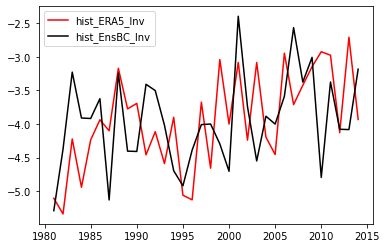

In [23]:
MTs=[]
for c in rhTsACCESS.time:
        
    MTs.append((rhTsACCESS.sel(time=c)+rhTsIPSL.sel(time=c)+
                rhTsEC.sel(time=c))/3.0)
    
ensFu=rhTsACCESS.copy()
ensFu.values=MTs


MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensFu=rhTsACCESS.copy()
ensFu.values=MTs

ensFuMean=ensFu.groupby('time.dayofyear').mean()
ensFuStd=ensFu.groupby('time.dayofyear').std()

### Change factor

BC=[]


for d in ensFu.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBC = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
#print(ensFuBC)
#print(ensFu)

#print(ensFuBC)
#print(cnnObs)


x=np.arange(1981,2015)
EnsBCHist=[]
#print(rhTs.time)
for yr in x :
    InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
    EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
    rhT=ensFuBC.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
    EnsBCHist.append(rhT.mean().values)
    
    #print(yr)

#print(y)

plt.plot(x,ObsERA5,label='hist_ERA5_Inv', color='red')
plt.plot(x,EnsBCHist,label='hist_EnsBC_Inv', color='black')
plt.legend()



/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


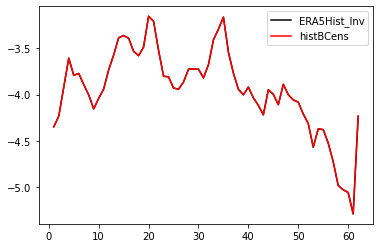

In [24]:
x=np.arange(1,63)
plt.plot(x,histRH,label='ERA5Hist_Inv', color='black')
ensFuBCHistMean1=ensFuBC.groupby('time.dayofyear').mean()
ensFuBCHistMean2=ensFuBCHistMean1.roll(dayofyear=31)
histBCens=ensFuBCHistMean2[(ensFuBCHistMean2.dayofyear<366) | (ensFuBCHistMean2.dayofyear>366)]
plt.plot(x,histBCens,label='histBCens', color='red')
plt.legend()
plt.savefig('histEnsBCTS.eps')
plt.show()

df=ensFuBC.to_dataframe(name='histEnsBCTS')
#np.savetxt('histEnsTS.txt', df.values, fmt='%1.3f')



In [25]:
######### Future proj

In [34]:
ssps=['126','245','370','585']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


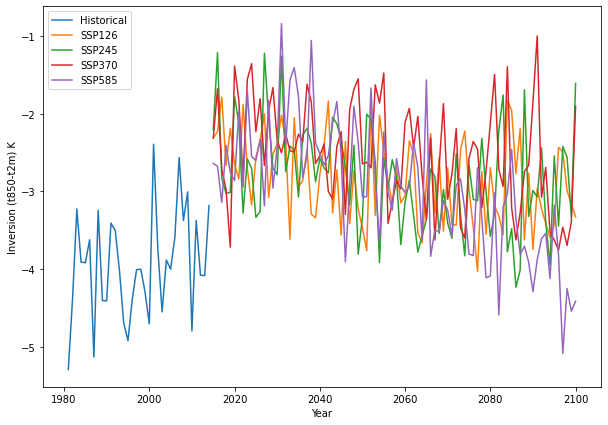

In [27]:
fig = plt.figure(figsize=(10,7))

x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_inv')
plt.plot(x,EnsBCHist,label='Historical')
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp)


plt.legend()

plt.xlabel('Year') 
plt.ylabel('Inversion (t850-t2m) K')
plt.savefig('inversion_ts.eps')
plt.show()
    
    #print(yr)


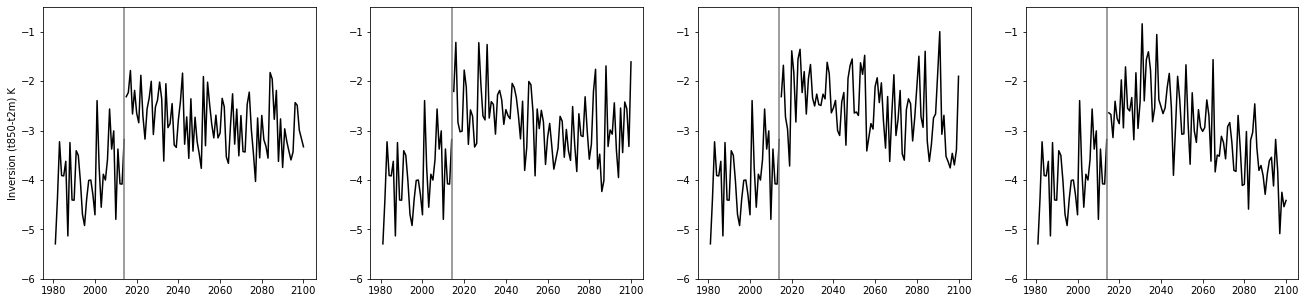

In [28]:
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    x=np.arange(1981,2015)

    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='black')
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='black')
    #plt.title('SSP'+sp)
    plt.ylim(-6,-0.5)
    if i == 1:
        plt.ylabel('Inversion (t850-t2m) K')
    plt.axvline(x=2014,color='grey')
    i=i+1


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('Inversion (t850-t2m) K')
plt.savefig('inversion_ts_panel.eps')
plt.show()
    
    #print(yr)


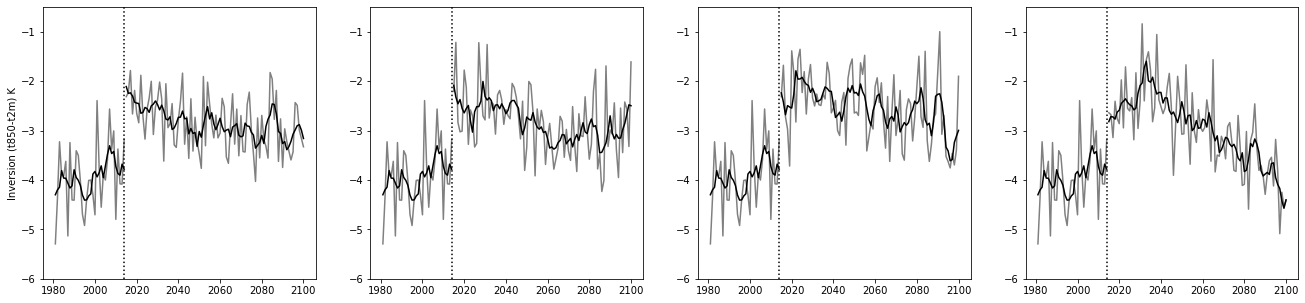

In [29]:
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    x=np.arange(1981,2015)

    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='grey')
    S = pd.Series (EnsBCHist)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
    
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='grey')
    S = pd.Series (EnsBCFu)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(xFu,rENS,label='SSP'+sp,color='black')
    #plt.title('SSP'+sp)
    plt.ylim(-6,-0.5)
    if i == 1:
        plt.ylabel('Inversion (t850-t2m) K')
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('Inversion (t850-t2m) K')
plt.savefig('inversion_ts_panel_5ymean.eps')
plt.show()
    
    #print(yr)


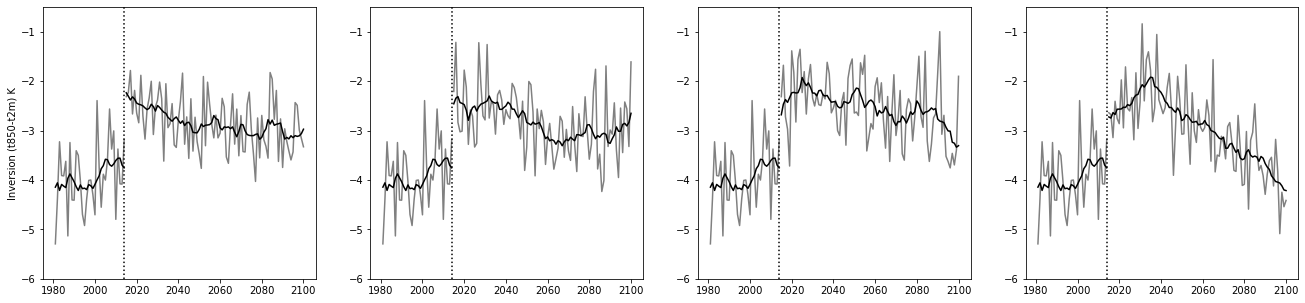

In [30]:
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    x=np.arange(1981,2015)

    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='grey')
    S = pd.Series (EnsBCHist)
    rENS=S.rolling(10, center=True, min_periods=1).mean()
    plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
    
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='grey')
    S = pd.Series (EnsBCFu)
    rENS=S.rolling(10, center=True, min_periods=1).mean()
    plt.plot(xFu,rENS,label='SSP'+sp,color='black')
    #plt.title('SSP'+sp)
    plt.ylim(-6,-0.5)
    if i == 1:
        plt.ylabel('Inversion (t850-t2m) K')
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('Inversion (t850-t2m) K')
plt.savefig('inversion_ts_panel_10ymean.eps')
plt.show()
    
    #print(yr)


In [32]:
#ssps=['126']

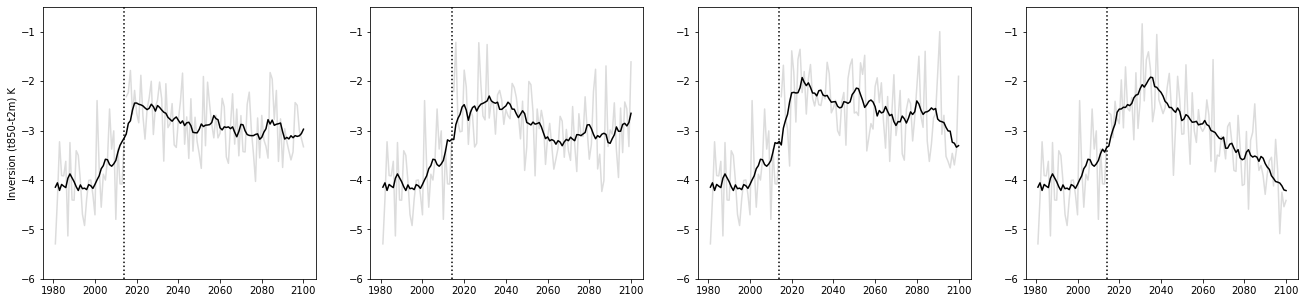

In [36]:
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:
    
    x=np.arange(1981,2015)

    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='gainsboro')
    
    #print(EnsBCHist)

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    #S = pd.Series (EnsBCHist)
    #rENS=S.rolling(10, center=True, min_periods=1).mean()
    #plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
    
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='gainsboro')
    jointList=EnsBCHist+EnsBCFu
    S = pd.Series (jointList)
    xTotal=np.arange(1981,2101)
    rENS=S.rolling(10, center=True, min_periods=1).mean()
    plt.plot(xTotal,rENS,label='SSP'+sp,color='black')
    #plt.title('SSP'+sp)
    plt.ylim(-6,-0.5)
    if i == 1:
        plt.ylabel('Inversion (t850-t2m) K')
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('Inversion (t850-t2m) K')
plt.savefig('inversion_ts_panel_10ymean.eps')
plt.show()
    
    #print(yr)


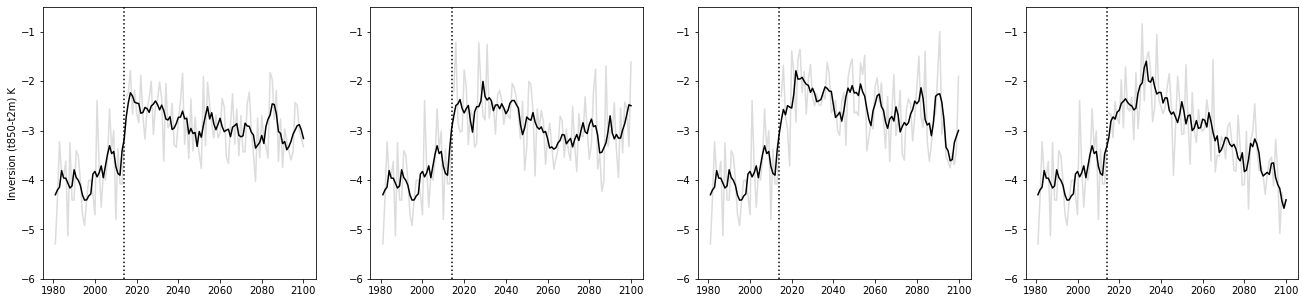

In [37]:
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:
    
    x=np.arange(1981,2015)

    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='gainsboro')
    
    #print(EnsBCHist)

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData=xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
   # tLevData = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')

    t2mD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    inv_ds.attrs
    inv_ds.attrs['units']='K'
    inv_ds.attrs['long_name']='t850 - t2m'
    # apply mask
    inv_ds.inv.values=inv_ds.inv.values*mask
    rhD  = inv_ds.inv.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    #S = pd.Series (EnsBCHist)
    #rENS=S.rolling(10, center=True, min_periods=1).mean()
    #plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
    
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='gainsboro')
    jointList=EnsBCHist+EnsBCFu
    S = pd.Series (jointList)
    xTotal=np.arange(1981,2101)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(xTotal,rENS,label='SSP'+sp,color='black')
    #plt.title('SSP'+sp)
    plt.ylim(-6,-0.5)
    if i == 1:
        plt.ylabel('Inversion (t850-t2m) K')
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('Inversion (t850-t2m) K')
plt.savefig('inversion_ts_panel_5ymean.eps')
plt.show()
    
    #print(yr)
